In [1]:
import os, csv, pickle, gzip, torch

import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm

from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
from matplotlib.collections import LineCollection

### Read Files

In [2]:
def read_gzip(path):    
    # All VERSIONs should match (pickle, python, pandas)
    output = []
    assert os.path.exists(path), 'ReadGzip Assertion: path is null: {0}'.format(path)
    with gzip.open(path, 'rb') as file:
        print("open gzip")
        output = pickle.load(file)     
    return output

#=======================================================================================
# features(ffile):   return [trimX, trimY, trimAnimTs, trimGTPos, trimHmdTs, trimHmd1Ts, trimEyeTs, self.l_trim_idx]
# sorted_params(sfile):  (row=subject) (column=file_num)

spath = "data/data_feature/sorted-params.csv"
sfile = open(spath, 'r', encoding='utf-8')
sfile = list(csv.reader(sfile))

file_name = "0814-f18"
fpath = "data/data_feature/" + file_name + ".gz"
ffile = read_gzip(fpath)

open gzip


### Func: conversions

In [3]:
# pos_to_param
# param_to_hmd1_pos
# hmd_pos_to_hmd1_pos
# hmd_pos_to_eye_pose


def pos_to_param(input):   
    '''
    input: true spherical position
    output: true rectilinear param
    ''' 
    l_output = []
    for idx, pos in enumerate(input):
        x, y, z = pos[0], pos[1], pos[2]
        hor = np.arctan(-x/z) * 180 / np.pi
        ver = np.arctan(y/z) * 180 / np.pi
        dist = np.sqrt(x*x + y*y + z*z)
        param = torch.tensor([hor, ver, dist], dtype=torch.float32)
        l_output.append(param)
    l_output = torch.stack(l_output)
    return l_output      


def param_to_hmd1_pos(relParams, hmd_tensor, hmd_1st_tensor):
    '''
    > INPUT: relParams(h,v,d), hmd_tensor(TF), hmd_tensor1(TF)
    > TRUE SPHERICAL Y SETUP, UNITY -X SETUP
    > Perform relParams -> relTensors
    > Perform (A) T (A)^-1
    TENSOR LIST FOR SINGLE FRAME SEQ
    input: e.g.[2200, 3], e.g. [2200, 4, 4]
    return: e.g. [2200, 3]
    '''
    l_output= []
    for frame, (param, hmd, hmd_1st) in enumerate(zip(relParams, hmd_tensor, hmd_1st_tensor)):
        # 1. change param to ts
        h, v, d = param[0], param[1], param[2]
        H = h * torch.pi / 180
        V = v * torch.pi / 180
        x = -(d) * torch.sin(H) * torch.cos(V)
        y = (d) * torch.cos(H) * torch.sin(V)   
        z = (d) * torch.cos(H) * torch.cos(V)         
        t = torch.eye(4, dtype=torch.float32)
        t[:3, 3] = torch.tensor([x,y,z], dtype=torch.float32)

        # 2. We wanted only relative position not global position in this case
        t = torch.matmul(hmd, t)
        t = torch.matmul(torch.linalg.inv(hmd_1st), t)

        l_output.append(t[:3, 3])
    l_output = torch.stack(l_output)

    return l_output

def hmd_pos_to_hmd1_pos(GTPos, hmd_1st_tensor):
    '''
    >TRUE SPHERICAL Y SETUP, UNITY -X SETUP
    TENSOR LIST FOR SINGLE FRAME SEQ
    input: e.g.[2200, 3], [2200, 4, 4]
    return: e.g. [2200, 3]
    '''
    l_output= []
    for frame, (gt_pos, hmd_1st) in enumerate(zip(GTPos, hmd_1st_tensor)):
        t_op = torch.eye(4)
        x,y,z = gt_pos[0], gt_pos[1], gt_pos[2]
        t_op[:3, 3] = torch.tensor([x,y,z], dtype=torch.float32)
        t_oh = hmd_1st 
        # t_hp = t_ho * t_op = inv(t_oh) * t_op
        t = torch.matmul(torch.linalg.inv(t_oh), t_op)
        l_output.append(t[:3, 3])
    l_output = torch.stack(l_output)

    return l_output


def hmd_pos_to_eye_pose(relParams, hmd_tensor, hmd1_tensor, eye_tensor, eye1_tensor):
    """
    INPUT: relParams(h,v,d), TF(hmd), TF(eye)
    FUNC1: make hmdeye1
    FUNC1: relParams -> relTransforms
    FUNC2: make hmdeye & hmdeye1
    FUNC3: plot eye transform trajectory
    """
    l_output_c = []
    l_output_l = []
    l_output_r = []
    
    for frame, (param, hmd, hmd1, eye, eye1) in enumerate(zip(relParams, hmd_tensor, hmd1_tensor, eye_tensor, eye1_tensor)):
        
        # 1. change param to ts
        h, v, d = param[0], param[1], param[2]
        H = h * torch.pi / 180
        V = v * torch.pi / 180
        x = -(d) * torch.sin(H) * torch.cos(V)
        y = (d) * torch.cos(H) * torch.sin(V)   
        z = (d) * torch.cos(H) * torch.cos(V)         
        t = torch.eye(4, dtype=torch.float32)
        t[:3, 3] = torch.tensor([x,y,z], dtype=torch.float32)    

        # 2. Make HMDEYE & HMDEYE1
        eye_c = eye[0]
        eye_l = eye[1]
        eye_r = eye[2]
        eye_c1 = eye1[0]
        eye_l1 = eye1[1]
        eye_r1 = eye1[2]
        
        # print("hmd, eye_c", hmd.shape, eye_c.shape, eye_l.shape, eye_r.shape)
        hmdeye_c = torch.matmul(hmd, eye_c)
        hmdeye_c1 = torch.matmul(hmd1, eye_c1)
        hmdeye_l = torch.matmul(hmd, eye_l)
        hmdeye_l1 = torch.matmul(hmd1, eye_l1)
        hmdeye_r = torch.matmul(hmd, eye_r)
        hmdeye_r1 = torch.matmul(hmd1, eye_r1)        
        
        # 3. We wanted only relative position not global position in this case
        t_c = torch.matmul(hmdeye_c, t)
        t_c = torch.matmul(torch.linalg.inv(hmdeye_c1), t_c)
        t_l = torch.matmul(hmdeye_l, t)
        t_l = torch.matmul(torch.linalg.inv(hmdeye_l1), t_l)
        t_r = torch.matmul(hmdeye_r, t)
        t_r = torch.matmul(torch.linalg.inv(hmdeye_r1), t_r)

        l_output_c.append(t_c[:3, 3])
        l_output_l.append(t_l[:3, 3])
        l_output_r.append(t_r[:3, 3])
        
    l_output_c = torch.stack(l_output_c)
    l_output_l = torch.stack(l_output_l)
    l_output_r = torch.stack(l_output_r)

    return l_output_c, l_output_l, l_output_r
    
    

### Func: draw_features_by_file

In [30]:
def draw_features_by_file(file_name, save_name, ffile, sfile):
    # GT position is not showing the pattern
    fig, (ax) = plt.subplots(1,1)
    fig.set_size_inches(8,8)
    plt.title("All")
    for fIdx in tqdm(range(144)):        
        colors = cm.rainbow(np.linspace(0, 1, 24))
        # fig, (ax) = plt.subplots(1,1)
        # fig.set_size_inches(8,8)
        # plt.title('file_num: '+str(fIdx+1)+ "/144")

        for sIdx in range(16):
            pIdx = int(sfile[sIdx][fIdx]) #pointer idx
            trimX,trimY,_,trimGTPos, trimHmd,trimHmd1,trimEye,trimEye1,_ = ffile[sIdx]
            # print("trimEye, trimEye1", trimHmd[0].shape, trimEye[0].shape, trimEye1[0].shape)
            # print("trimHmd, trimEye, trimEye1", len(trimHmd), len(trimEye), len(trimEye1))

            # ----seq mode & trim hmd,GT,Y------------            
            end_idx = len(trimX[pIdx])-1
            trimHmd = trimHmd[pIdx][:end_idx+1]     #ts
            trimHmd1 = trimHmd1[pIdx][:end_idx+1]     #ts
            trimEye = trimEye[pIdx][:end_idx+1]
            trimEye1 = trimEye1[pIdx][:end_idx+1]
            trimGTPos =trimGTPos[pIdx][:end_idx+1]   #pos
            trimY = trimY[pIdx][:end_idx+1]         #rel_params

            trimHmd = trimHmd[::5]  
            trimHmd1 = trimHmd1[::5]
            trimEye = trimEye[::5]
            trimEye1 = trimEye1[::5]   
            trimGTPos =trimGTPos[::5]  
            trimY = trimY[::5]  
            
            #----------plot--------------------------------------
            if len(trimX[pIdx]) == 0:
                pos0 = torch.full((20, 3), -1)
                pos1 = torch.full((20, 3), -1)
                pos_eye_c = torch.full((20, 3), -1)
                pos_eye_left = torch.full((20, 3), -1)
                pos_eye_right = torch.full((20, 3), -1)
            else:
                pos0 = hmd_pos_to_hmd1_pos(trimGTPos, trimHmd1) #GT
                pos1 = param_to_hmd1_pos(trimY, trimHmd1, trimHmd1) # 
                pos_eye_c, pos_eye_l, pos_eye_r = hmd_pos_to_eye_pose(trimY, trimHmd, trimHmd1, trimEye, trimEye1)


            # pos0 = pos_to_param(pos0)
            # pos1 = pos_to_param(pos1)
            # pos_eye_c = pos_to_param(pos_eye_c)
            # pos_eye_left = pos_to_param(pos_eye_left)
            # pos_eye_right = pos_to_param(pos_eye_right)

            x0, y0 = pos0[:,0], pos0[:,1]
            # x1, y1 = pos1[:,0], pos1[:,1]
            x_c, y_c = pos_eye_c[:,0], pos_eye_c[:,1]
            # x_l, y_l = pos_eye_left[:,0], pos_eye_left[:,1]
            # x_r, y_r = pos_eye_right[:,0], pos_eye_right[:,1]

            color = np.array([colors[sIdx]])
            ax.scatter(x0, y0, c='g', marker='d', label='gts', alpha=0.2)
            # ax.scatter(x1, y1, c=color, marker='+', label='ydata', alpha=0.2)
            # ax.scatter(x1[-1], y1[-1], c='r', marker='s', alpha=1)
            ax.scatter(x_c, y_c, c=color, marker='.', label='comb', alpha=0.2)
            # ax.scatter(x_l, y_l, c=color, marker='o', label='left', alpha=0.2)
            # ax.scatter(x_r, y_r, c=color, marker='x', label='right', alpha=0.2)

            pos1_text = 's' + str(sIdx+1) 
            # ax.text(x1[-1], y1[-1], pos1_text)
            ax.set_xlabel('X (meter)')
            ax.set_ylabel('Y (meter)')            
            # ax.set_xlabel('H (degree)')
            # ax.set_ylabel('V (degree)')

        plt.xlim([-45,45])
        plt.ylim([-45,45])
        plt.xlim([-2,2])
        plt.ylim([-2,2])

        plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)        

        savename = "f" + str(fIdx+1)
        # fig.savefig(savename)
        #plt.show()        # plt.legend()
    fig.savefig(savename)
 

  0%|                                                                                          | 0/144 [00:00<?, ?it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  1%|▌                                                                                 | 1/144 [00:00<00:54,  2.63it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  1%|█▏                                                                                | 2/144 [00:00<00:54,  2.62it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  2%|█▋                                                                                | 3/144 [00:01<00:58,  2.40it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  3%|██▎                                                                               | 4/144 [00:01<00:55,  2.51it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  3%|██▊                                                                               | 5/144 [00:01<00:54,  2.53it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  4%|███▍                                                                              | 6/144 [00:02<00:55,  2.48it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  5%|███▉                                                                              | 7/144 [00:02<00:54,  2.52it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  6%|████▌                                                                             | 8/144 [00:03<00:53,  2.55it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  6%|█████▏                                                                            | 9/144 [00:03<00:53,  2.53it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  7%|█████▋                                                                           | 10/144 [00:03<00:53,  2.48it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  8%|██████▏                                                                          | 11/144 [00:04<00:53,  2.47it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  8%|██████▊                                                                          | 12/144 [00:04<00:56,  2.34it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


  9%|███████▎                                                                         | 13/144 [00:05<00:54,  2.40it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


 10%|███████▉                                                                         | 14/144 [00:05<00:53,  2.44it/s]

trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144
trimEye, trimEye1 144 144 144


KeyboardInterrupt: 

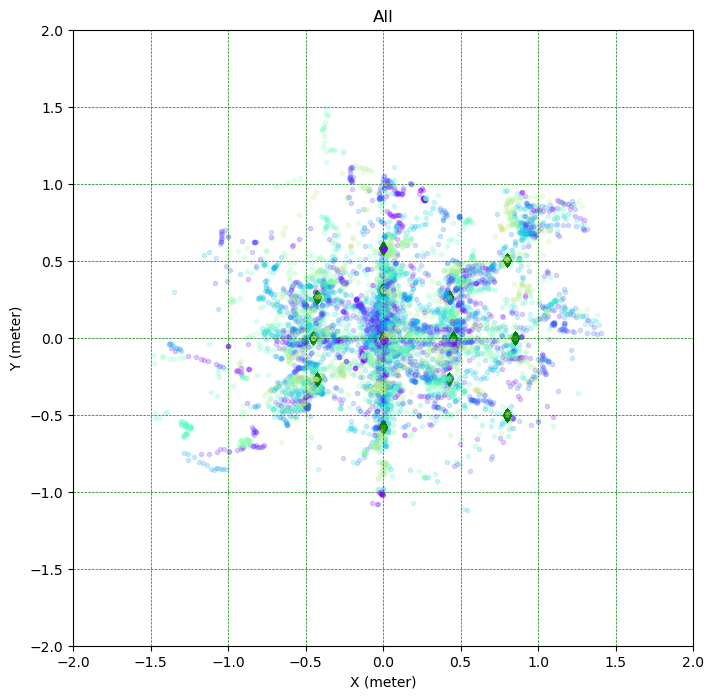

In [31]:
# draw_features_by_file(file_name, save_name, ffile, sfile)
draw_features_by_file(file_name, "testtest", ffile, sfile)

### Func: draw_features_by_file

In [16]:
def draw_features_by_subject(file_name, save_name, ffile, sfile):
    # SET VARIABLES
    final_subject= 24
    
    # Master Plot
    fig, (ax) = plt.subplots(1,1)
    colors = cm.rainbow(np.linspace(0, 1, 16)) # 16 subjects
    colors = cm.rainbow(np.linspace(0, 1, 24)) # 24 subjects

    plt.title("subject")
    
    #SUBJECT LOOP
    for sIdx in tqdm(range(final_subject)):
        fig, (ax) = plt.subplots(1,1)
        fig.set_size_inches(10,10)
        fig.suptitle("subject: " + str(sIdx))
        print(colors[sIdx])
        
        # FILE LOOP
        for fIdx in range(144):
            pIdx = int(sfile[sIdx][fIdx]) #pointer idx
            trimX,trimY,_,trimGTPos, trimHmd,trimHmd1,trimEye,trimEye1,_ = ffile[sIdx]
            # print("trimHmd, trimEye, trimEye1", len(trimHmd), len(trimEye), len(trimEye1))
            # print(fIdx, len(trimHmd))
            

            # ----seq mode & trim hmd,GT,Y------------   
            
            
            end_idx = len(trimX[pIdx])-1
            t = np.arange(end_idx+1) 
            trimHmd = trimHmd[pIdx][:end_idx+1]
            trimHmd1 = trimHmd1[pIdx][:end_idx+1]
            trimEye = trimEye[pIdx][:end_idx+1]
            trimEye1 = trimEye1[pIdx][:end_idx+1]
            trimGTPos =trimGTPos[pIdx][:end_idx+1]   #pos
            trimY = trimY[pIdx][:end_idx+1]         #rel_params

            t = t[::5]
            trimHmd = trimHmd[::5]  
            trimHmd1 = trimHmd1[::5]
            trimEye = trimEye[::5]
            trimEye1 = trimEye1[::5]   
            trimGTPos =trimGTPos[::5]  
            trimY = trimY[::5]      
    
            #----------plot--------------------------------------
            colors = cm.rainbow(np.linspace(0, 1, end_idx)) # 24 subjects
        
            if len(trimX[pIdx]) == 0:
                pos0 = torch.full((20, 3), -1)
                pos1 = torch.full((20, 3), -1)
                pos_eye_c = torch.full((20, 3), -1)
                pos_eye_left = torch.full((20, 3), -1)
                pos_eye_right = torch.full((20, 3), -1)
            else:
                pos0 = hmd_pos_to_hmd1_pos(trimGTPos, trimHmd1) #GT
                pos1 = param_to_hmd1_pos(trimY, trimHmd1, trimHmd1) # 
                pos_eye_c, pos_eye_l, pos_eye_r = hmd_pos_to_eye_pose(trimY, trimHmd, trimHmd1, trimEye, trimEye1)    
    
    
            # pos0 = pos_to_param(pos0)
            # pos1 = pos_to_param(pos1)
            # pos_eye_c = pos_to_param(pos_eye_c)
            # pos_eye_left = pos_to_param(pos_eye_left)
            # pos_eye_right = pos_to_param(pos_eye_right)

            x0, y0 = pos0[:,0], pos0[:,1]
            # x1, y1 = pos1[:,0], pos1[:,1]
            x_c, y_c = pos_eye_c[:,0], pos_eye_c[:,1]
            # x_l, y_l = pos_eye_left[:,0], pos_eye_left[:,1]
            # x_r, y_r = pos_eye_right[:,0], pos_eye_right[:,1]


            ax.scatter(x0, y0, c='g', marker='d', label='gts', alpha=0.2)
            # ax.scatter(x1, y1, c=color, marker='+', label='ydata', alpha=0.2)
            # ax.scatter(x1[-1], y1[-1], c='r', marker='s', alpha=1)
            # ax.scatter(x_c, y_c, c=t, cmap=cm.viridis, marker='.', label='comb', alpha=0.01)
                        
            alphas= np.linspace(0,1,end_idx)
            ax.scatter(x_c, y_c, c='red', marker='o', label='comb', alpha=alphas)
            # ax.scatter(x_l, y_l, c=color, marker='o', label='left', alpha=0.2)
            # ax.scatter(x_r, y_r, c=color, marker='x', label='right', alpha=0.2)

            pos1_text = 's' + str(sIdx+1) 
            # ax.text(x1[-1], y1[-1], pos1_text)
            ax.set_xlabel('X (meter)')
            ax.set_ylabel('Y (meter)')            
            # ax.set_xlabel('H (degree)')
            # ax.set_ylabel('V (degree)')    

        # SUBJECT LOOP
        plt.xlim([-45,45])
        plt.ylim([-45,45])
        plt.xlim([-2,2])
        plt.ylim([-2,2])

        plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)        

        savename = "Subject-" + str(sIdx+1)
        fig.savefig(savename)
        plt.close()
        #plt.show()        # plt.legend()
    # fig.savefig(savename)
 

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

[0.5 0.  1.  1. ]


  4%|███▍                                                                               | 1/24 [00:04<01:36,  4.22s/it]

[0.49215686 0.01231966 0.99998103 1.        ]


  8%|██████▉                                                                            | 2/24 [00:08<01:32,  4.22s/it]

[0.48431373 0.02463745 0.99992411 1.        ]


 12%|██████████▍                                                                        | 3/24 [00:12<01:24,  4.01s/it]

[0.46078431 0.06156091 0.99952572 1.        ]


 17%|█████████████▊                                                                     | 4/24 [00:16<01:26,  4.31s/it]

[0.45294118 0.07385253 0.99931706 1.        ]


 21%|█████████████████▎                                                                 | 5/24 [00:20<01:19,  4.20s/it]

[0.45294118 0.07385253 0.99931706 1.        ]


 25%|████████████████████▊                                                              | 6/24 [00:24<01:11,  3.97s/it]

[0.39803922 0.15947579 0.99679532 1.        ]


 29%|████████████████████████▏                                                          | 7/24 [00:30<01:16,  4.50s/it]

[0.46862745 0.04925994 0.99969645 1.        ]


 33%|███████████████████████████▋                                                       | 8/24 [00:33<01:06,  4.15s/it]

[0.40588235 0.1473017  0.99726917 1.        ]


 38%|███████████████████████████████▏                                                   | 9/24 [00:36<00:58,  3.91s/it]

[0.36666667 0.20791169 0.9945219  1.        ]


 42%|██████████████████████████████████▏                                               | 10/24 [00:40<00:54,  3.92s/it]

[0.39803922 0.15947579 0.99679532 1.        ]


 46%|█████████████████████████████████████▌                                            | 11/24 [00:45<00:55,  4.23s/it]

[0.42941176 0.11065268 0.9984636  1.        ]


 50%|█████████████████████████████████████████                                         | 12/24 [00:49<00:47,  4.00s/it]

[0.36666667 0.20791169 0.9945219  1.        ]


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:53<00:46,  4.20s/it]

[0.41372549 0.13510525 0.99770518 1.        ]


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:57<00:39,  3.99s/it]

[0.35882353 0.21994636 0.99385914 1.        ]


 62%|███████████████████████████████████████████████████▎                              | 15/24 [01:01<00:36,  4.11s/it]

[0.36666667 0.20791169 0.9945219  1.        ]


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [01:04<00:30,  3.78s/it]

[0.27254902 0.34972651 0.98408634 1.        ]


 71%|██████████████████████████████████████████████████████████                        | 17/24 [01:08<00:26,  3.75s/it]

[0.27254902 0.34972651 0.98408634 1.        ]


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [01:12<00:23,  3.90s/it]

[0.33529412 0.25584278 0.9916447  1.        ]


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [01:16<00:19,  3.91s/it]

[0.28823529 0.32653871 0.98620075 1.        ]


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [01:19<00:14,  3.64s/it]

[0.14705882 0.52643216 0.96182564 1.        ]


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [01:24<00:11,  3.95s/it]

[0.29607843 0.31486959 0.98720184 1.        ]


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [01:28<00:08,  4.13s/it]

[0.24117647 0.39545121 0.97940977 1.        ]


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [01:32<00:04,  4.09s/it]

[0.24901961 0.38410575 0.98063477 1.        ]


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:36<00:00,  4.03s/it]


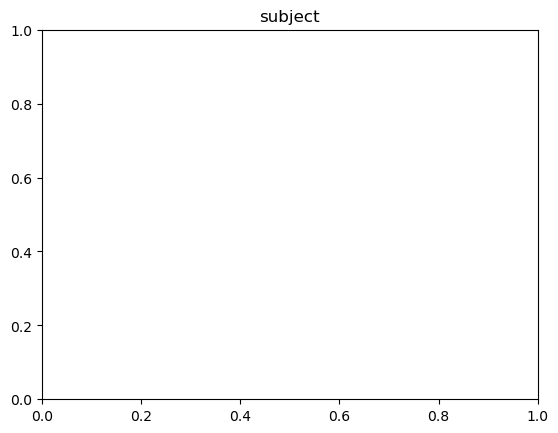

In [17]:
draw_features_by_subject(file_name, "ourtest", ffile, sfile)

### FUNC: 0.67sec buffer

In [22]:
def draw_features_by_subject_067(file_name, save_name, ffile, sfile):
    # SET VARIABLES
    final_subject= 24
    
    # Master Plot
    fig, (ax) = plt.subplots(1,1)
    colors = cm.rainbow(np.linspace(0, 1, 16)) # 16 subjects
    colors = cm.rainbow(np.linspace(0, 1, 24)) # 24 subjects

    plt.title("subject")
    
    #SUBJECT LOOP
    for sIdx in tqdm(range(final_subject)):
        fig, (ax) = plt.subplots(1,1)
        fig.set_size_inches(10,10)
        fig.suptitle("subject: " + str(sIdx))
        print(colors[sIdx])
        
        # FILE LOOP
        for fIdx in range(144):
            pIdx = int(sfile[sIdx][fIdx]) #pointer idx
            trimX,trimY,_,trimGTPos, trimHmd,trimHmd1,trimEye,trimEye1,_ = ffile[sIdx]
            # print("trimHmd, trimEye, trimEye1", len(trimHmd), len(trimEye), len(trimEye1))
            # print(fIdx, len(trimHmd))
            

            # ----seq mode & trim hmd,GT,Y------------   
            
            
            end_idx = len(trimX[pIdx])-1
            t = np.arange(end_idx+1) 
            trimHmd = trimHmd[pIdx][:end_idx+1]
            trimHmd1 = trimHmd1[pIdx][:end_idx+1]
            trimEye = trimEye[pIdx][:end_idx+1]
            trimEye1 = trimEye1[pIdx][:end_idx+1]
            trimGTPos =trimGTPos[pIdx][:end_idx+1]   #pos
            trimY = trimY[pIdx][:end_idx+1]         #rel_params

            t = t[::5]
            trimHmd = trimHmd[::5]  
            trimHmd1 = trimHmd1[::5]
            trimEye = trimEye[::5]
            trimEye1 = trimEye1[::5]   
            trimGTPos =trimGTPos[::5]  
            trimY = trimY[::5]      
            
            
            t = t[16:]
            trimHmd = trimHmd[16:]  
            trimHmd1 = trimHmd1[16:]
            trimEye = trimEye[16:]
            trimEye1 = trimEye1[16:]   
            trimGTPos =trimGTPos[16:]  
            trimY = trimY[16:] 
    
            #----------plot--------------------------------------
            colors = cm.rainbow(np.linspace(0, 1, end_idx)) # 24 subjects
        
            if len(trimX[pIdx]) == 0:
                pos0 = torch.full((20, 3), -1)
                pos1 = torch.full((20, 3), -1)
                pos_eye_c = torch.full((20, 3), -1)
                pos_eye_left = torch.full((20, 3), -1)
                pos_eye_right = torch.full((20, 3), -1)
            else:
                pos0 = hmd_pos_to_hmd1_pos(trimGTPos, trimHmd1) #GT
                pos1 = param_to_hmd1_pos(trimY, trimHmd1, trimHmd1) # 
                pos_eye_c, pos_eye_l, pos_eye_r = hmd_pos_to_eye_pose(trimY, trimHmd, trimHmd1, trimEye, trimEye1)    
    
    
            # pos0 = pos_to_param(pos0)
            # pos1 = pos_to_param(pos1)
            # pos_eye_c = pos_to_param(pos_eye_c)
            # pos_eye_left = pos_to_param(pos_eye_left)
            # pos_eye_right = pos_to_param(pos_eye_right)

            x0, y0 = pos0[:,0], pos0[:,1]
            # x1, y1 = pos1[:,0], pos1[:,1]
            x_c, y_c = pos_eye_c[:,0], pos_eye_c[:,1]
            # x_l, y_l = pos_eye_left[:,0], pos_eye_left[:,1]
            # x_r, y_r = pos_eye_right[:,0], pos_eye_right[:,1]


            ax.scatter(x0, y0, c='g', marker='d', label='gts', alpha=0.2)
            # ax.scatter(x1, y1, c=color, marker='+', label='ydata', alpha=0.2)
            # ax.scatter(x1[-1], y1[-1], c='r', marker='s', alpha=1)
            # ax.scatter(x_c, y_c, c=t, cmap=cm.viridis, marker='.', label='comb', alpha=0.01)
                        
            alphas= np.linspace(0,1,end_idx)
            ax.scatter(x_c, y_c, c='red', marker='o', label='comb', alpha=alphas)
            # ax.scatter(x_l, y_l, c=color, marker='o', label='left', alpha=0.2)
            # ax.scatter(x_r, y_r, c=color, marker='x', label='right', alpha=0.2)

            pos1_text = 's' + str(sIdx+1) 
            # ax.text(x1[-1], y1[-1], pos1_text)
            ax.set_xlabel('X (meter)')
            ax.set_ylabel('Y (meter)')            
            # ax.set_xlabel('H (degree)')
            # ax.set_ylabel('V (degree)')    

        # SUBJECT LOOP
        plt.xlim([-45,45])
        plt.ylim([-45,45])
        plt.xlim([-2,2])
        plt.ylim([-2,2])

        plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)        

        savename = "Subject-" + str(sIdx+1) + '-' + save_name
        fig.savefig(savename)
        plt.close()
        #plt.show()        # plt.legend()
    # fig.savefig(savename)
 

  0%|                                                                                           | 0/24 [00:00<?, ?it/s]

[0.5 0.  1.  1. ]


  4%|███▍                                                                               | 1/24 [00:02<01:07,  2.92s/it]

[0.49215686 0.01231966 0.99998103 1.        ]


  8%|██████▉                                                                            | 2/24 [00:06<01:11,  3.24s/it]

[0.48431373 0.02463745 0.99992411 1.        ]


 12%|██████████▍                                                                        | 3/24 [00:08<00:59,  2.85s/it]

[0.46078431 0.06156091 0.99952572 1.        ]


 17%|█████████████▊                                                                     | 4/24 [00:12<01:01,  3.10s/it]

[0.45294118 0.07385253 0.99931706 1.        ]


 21%|█████████████████▎                                                                 | 5/24 [00:15<00:56,  2.97s/it]

[0.45294118 0.07385253 0.99931706 1.        ]


 25%|████████████████████▊                                                              | 6/24 [00:16<00:45,  2.55s/it]

[0.39803922 0.15947579 0.99679532 1.        ]


 29%|████████████████████████▏                                                          | 7/24 [00:21<00:53,  3.12s/it]

[0.46862745 0.04925994 0.99969645 1.        ]


 33%|███████████████████████████▋                                                       | 8/24 [00:23<00:44,  2.80s/it]

[0.40588235 0.1473017  0.99726917 1.        ]


 38%|███████████████████████████████▏                                                   | 9/24 [00:25<00:38,  2.59s/it]

[0.36666667 0.20791169 0.9945219  1.        ]


 42%|██████████████████████████████████▏                                               | 10/24 [00:28<00:37,  2.65s/it]

[0.39803922 0.15947579 0.99679532 1.        ]


 46%|█████████████████████████████████████▌                                            | 11/24 [00:31<00:37,  2.91s/it]

[0.42941176 0.11065268 0.9984636  1.        ]


 50%|█████████████████████████████████████████                                         | 12/24 [00:33<00:32,  2.68s/it]

[0.36666667 0.20791169 0.9945219  1.        ]


 54%|████████████████████████████████████████████▍                                     | 13/24 [00:37<00:31,  2.90s/it]

[0.41372549 0.13510525 0.99770518 1.        ]


 58%|███████████████████████████████████████████████▊                                  | 14/24 [00:39<00:26,  2.69s/it]

[0.35882353 0.21994636 0.99385914 1.        ]


 62%|███████████████████████████████████████████████████▎                              | 15/24 [00:42<00:25,  2.86s/it]

[0.36666667 0.20791169 0.9945219  1.        ]


 67%|██████████████████████████████████████████████████████▋                           | 16/24 [00:44<00:19,  2.48s/it]

[0.27254902 0.34972651 0.98408634 1.        ]


 71%|██████████████████████████████████████████████████████████                        | 17/24 [00:46<00:17,  2.45s/it]

[0.27254902 0.34972651 0.98408634 1.        ]


 75%|█████████████████████████████████████████████████████████████▌                    | 18/24 [00:49<00:15,  2.61s/it]

[0.33529412 0.25584278 0.9916447  1.        ]


 79%|████████████████████████████████████████████████████████████████▉                 | 19/24 [00:52<00:13,  2.63s/it]

[0.28823529 0.32653871 0.98620075 1.        ]


 83%|████████████████████████████████████████████████████████████████████▎             | 20/24 [00:53<00:09,  2.36s/it]

[0.14705882 0.52643216 0.96182564 1.        ]


 88%|███████████████████████████████████████████████████████████████████████▊          | 21/24 [00:57<00:07,  2.65s/it]

[0.29607843 0.31486959 0.98720184 1.        ]


 92%|███████████████████████████████████████████████████████████████████████████▏      | 22/24 [01:00<00:05,  2.84s/it]

[0.24117647 0.39545121 0.97940977 1.        ]


 96%|██████████████████████████████████████████████████████████████████████████████▌   | 23/24 [01:03<00:02,  2.82s/it]

[0.24901961 0.38410575 0.98063477 1.        ]


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [01:05<00:00,  2.74s/it]


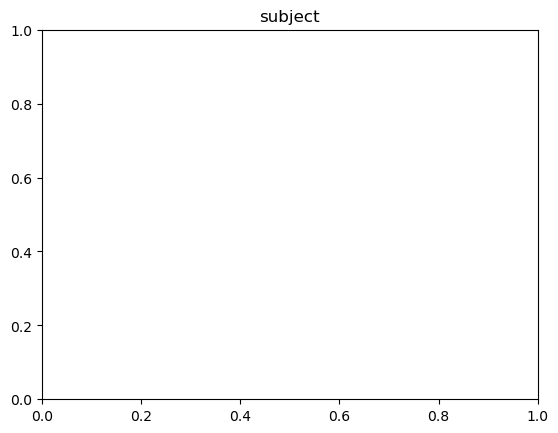

In [23]:
draw_features_by_subject_067(file_name, "067buffer", ffile, sfile)